# **COMP3670/6670 Assignment 4 - GMM**
---

**Enter Your Student ID:** u6284513

**Your Name:** 
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- u6548263
- u6481081
- <Enter ID 3>
    

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 10%
- 5 = 10%
- 6 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import functools
# import multivariate_normal
from scipy.stats import multivariate_normal
# import sklearn kmeans class
from sklearn.cluster import KMeans

We're going to implement an algorithm to model data with a mixture of Gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional Gaussian components involved, as well as their means.

Not only this, but the "distance" between each of your data points (a row $d_i$ of $D$) and a Gaussian $k$, is the probability of that point generated by that Gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

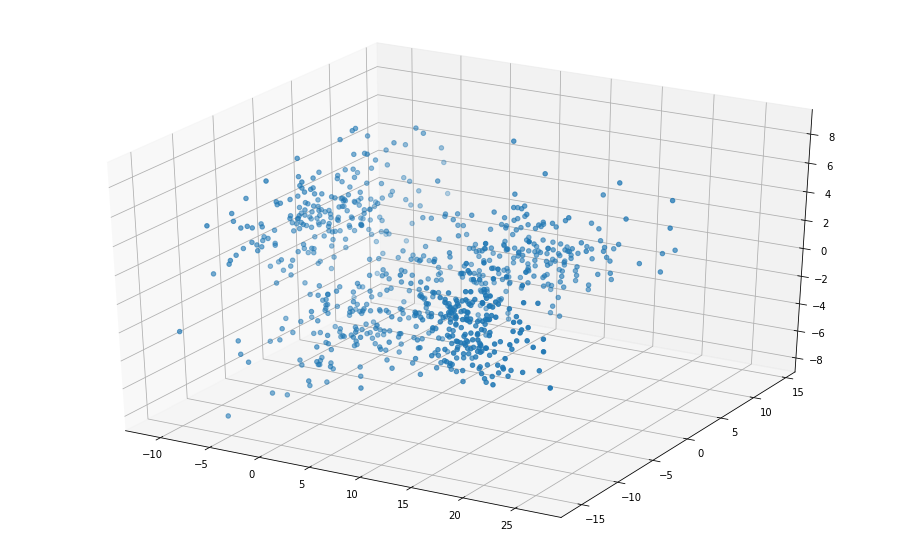

In [2]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset containing 800 data points. Each data point has 4 dimensions. The first three dimensions can be represented by a three dimensional Gaussian Mixture Model. The forth dimension contains catogorical information for that data point. 

**You only need the first three dimensions of the data in task 1 through 5. The forth dimension is for task 6 only.**.

$K$ is the total number of Gaussians. This is just like the $K$ mean vectors you had for k-means in assignment 2. Each Gaussian is named $k$, where $k$ is the unique number associated with that Gaussian. For example, the first Gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a Gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilies, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ mean vectors, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**You only need the first three dimensions of the data in task 1 through 5. The forth dimension is for task 6 only.**

---

In [3]:
def initialise_parameters(X, K):
    m = 3
    N = X.shape[0]
    sigma = np.zeros((K, m, m))
    mu = np.zeros((K, m))
    pi = np.zeros(K)
    
    # YOUR CODE HERE
    Kmean = KMeans(n_clusters=K)
    Kmean.fit(X)
    Kchoice = Kmean.labels_ 
    
    #random pick the value
    Kinitial = [[] for _ in range(K)]
    
    for i in range(K):
        for j in range(N):
            # if the id is i then append to that index
            if (Kchoice[j] == i):
                Kinitial[i].append(X[:,:m][j])

    # get the mean Kinitial
    for i in range(K):
        mu[i] = np.mean(np.array(Kinitial[i]),axis = 0)
    
    for i in range(K):
        for j in range(m):
            for k in range(m):
                sigma[i][j][k] = np.asmatrix(Kinitial[i][j] - mu[j])@np.asmatrix(Kinitial[i][k] - mu[k]).T
    # give the probabilities 1/k
    for j in range(K):
        pi[j] = 1/K
    return sigma, mu, pi
    
K = 4
sigma, mu, pi = initialise_parameters(X, K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[  11.31653934   37.98839792   27.08459815]
  [  37.98839792  483.79150851 -105.57704755]
  [  27.08459815 -105.57704755  173.20973741]]

 [[ 105.80273294  -58.45923519  186.06533935]
  [ -58.45923519   33.01758668 -111.54987103]
  [ 186.06533935 -111.54987103  471.17147999]]

 [[  79.92028706   91.92475752  -22.21860995]
  [  91.92475752  413.11586331 -115.92394416]
  [ -22.21860995 -115.92394416   65.38669817]]

 [[  78.68709193  -42.38304803  107.86899454]
  [ -42.38304803   41.7874335   -89.25263928]
  [ 107.86899454  -89.25263928  297.38970287]]]

Mu: 
 [[ 11.4496915    2.9986603    0.76626907]
 [ -6.52345044   1.20042586   1.94928516]
 [ 15.20599329 -10.01900315  -0.08224641]
 [  0.74240932  -4.53538431  -2.93925957]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of Gaussians you're attempting to cluster the data with. Each Gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the Gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that guassian.

You cannot use euclidean distance like you did with the k-means algorithm in Assignment 2.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [5]:
def E_step(pi, mu, sigma, X):
    N = X.shape[0]
    m = 3
    r = np.zeros((N, K))
    # YOUR CODE HERE
    for i in range(N):
        r_ij = 0
        for j in range(K):
            r_ij += pi[j] * multivariate_normal.pdf(X[i][:m], mean = mu[j], cov = sigma[j] )

        for k in range(K):
            r_ik = pi[k] * multivariate_normal.pdf(X[i][:m], mean = mu[k], cov = sigma[k] )
            r[i][k] = r_ik/r_ij
            
    return r

responsibilities = E_step(pi, mu, sigma, X)
print(responsibilities)

[[7.70621510e-241 7.22675703e-001 2.77324076e-001 2.21824482e-007]
 [7.58041609e-241 4.13365610e-001 5.86634145e-001 2.45187588e-007]
 [1.99956815e-109 7.61801331e-001 2.38114752e-001 8.39169845e-005]
 ...
 [6.14618321e-002 6.77033243e-005 8.27214091e-001 1.11256374e-001]
 [2.38011501e-038 2.05990355e-007 9.95688418e-001 4.31137641e-003]
 [1.23771634e-064 2.43597687e-009 9.99261780e-001 7.38217945e-004]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ Gaussians, along with the priors $\pi$.

---

In [6]:
def M_step(r, X):
    K = r.shape[1]
    N = X.shape[0]
    m = 3
    mu = np.zeros((K, m))
    sigma = np.zeros((K, m, m))
    pi = np.zeros(K)
    
    #calculate the N_k
    N_k = np.sum(r,axis = 0)
    pi = N_k/N
    for i in range(K):
        mu[i] = ((X.T@r[:,i])/N_k)[:m]
        r_nk = np.zeros((m,m))
        for j in range(N):
            r_nk += r[j,i] * np.matrix(X[j,:m] - mu[i]).T@np.matrix((X[j,:m]- mu[i]))
        sigma[i] = r_nk/N_k[i]

    # YOUR CODE HERE
    return mu, sigma, pi

mu, sigma, pi = M_step(responsibilities, X)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 1.08169312e+01 -1.81690385e+01 -4.24850593e+00]
  [-1.81690385e+01  3.49960153e+01  1.20620155e+01]
  [-4.24850593e+00  1.20620155e+01  9.85831447e+00]]

 [[ 6.47231526e+02  1.25466524e+01 -1.87651706e+00]
  [ 1.25466524e+01  5.87227492e+00 -2.11528938e-01]
  [-1.87651706e+00 -2.11528938e-01  5.44819859e+00]]

 [[ 3.81841541e+03 -9.44770018e+01  1.17556683e+00]
  [-9.44770018e+01  3.07860015e+01  7.52800363e-01]
  [ 1.17556683e+00  7.52800363e-01  5.02724737e+00]]

 [[ 2.25148147e+02 -1.09492608e+01 -6.95045200e+00]
  [-1.09492608e+01  3.16423724e+01  1.09666729e+01]
  [-6.95045200e+00  1.09666729e+01  1.14487300e+01]]]

Mu: 
 [[-1.37545463e+00 -1.04910996e-01 -2.86248352e-01]
 [ 2.99331047e+01  1.98956829e+00  6.09606794e-01]
 [ 7.40114756e+01 -8.19918089e+00 -1.09799812e-01]
 [-1.92562290e+01 -1.38862684e+00 -1.96686562e-02]]

Pi: 
 [0.06250525 0.3122499  0.36923754 0.25600732]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [7]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE

    N = mu.shape[0]
    col = x.shape[0]
    prob = np.zeros(N)
    
    for i in range(N):
        prob[i] = multivariate_normal.pdf(x,mean = mu[i], cov = sigma[i])*pi[i]
    
    return np.argmax(prob)

print(classify(pi, mu, sigma, X[270, :3]))

0


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many Gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[17.78772433  5.21359249  1.73098349]
  [ 5.21359249 15.24995912  3.93217113]
  [ 1.73098349  3.93217113  3.11459215]]

 [[ 2.14318803  4.46509644  0.91212225]
  [ 4.46509644 23.7656719  -1.12457027]
  [ 0.91212225 -1.12457027  4.70465838]]

 [[14.49270023 -5.52174355  1.9655405 ]
  [-5.52174355  3.20250847 -0.29131079]
  [ 1.9655405  -0.29131079  3.89699931]]

 [[25.77489975  0.34519719  3.29373193]
  [ 0.34519719  1.7667958  -0.12191504]
  [ 3.29373193 -0.12191504  4.26585786]]]

Mu: 
 [[  1.372907    -3.68109313  -2.74225832]
 [ -7.03717866   1.00739883   2.14589541]
 [ 15.41285464 -10.16743585  -0.0381021 ]
 [ 11.32409249   3.19421279   0.91823592]]

Pi: 
 [0.24712065 0.24933436 0.2522861  0.25125889]


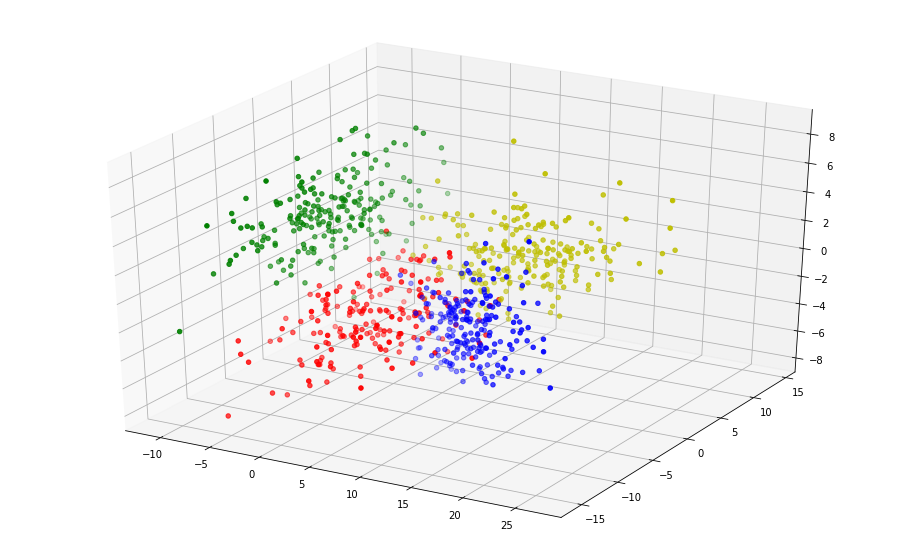

In [8]:
def EM(X, K, iterations):
    # YOUR CODE HERE
    m = 3
    mu = np.zeros((K, m))
    sigma = np.zeros((K, m, m))
    pi = np.zeros(K)
    sigma, mu, pi = initialise_parameters(X, K)
    for j in range(iterations):
        r = E_step(pi, mu, sigma, X)
        mu, sigma, pi = M_step(r, X)
    return mu, sigma, pi


#Test code. Leave it aloooooone!
iterations = 30
K = 4
mu, sigma, pi = EM(X, K, iterations)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi, mu, sigma, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

Now we start to use the fourth dimension, which indicates the category of each data point.  

The possible values for the forth dimension are 1, 2, 3, 4, 5. 

**Task 6:** Compute the Conditional Distribution.
Use the function from the Task 4. Use the $\mu, \pi, \Sigma$ from Task 5.

Let $K$ stands for the classification result of the first three dimensions, $Y$ stand for the value of the forth dimension. 

Possible $k$ values are 0, 1, 2, 3. Possible $y$ values are 1, 2, 3, 4, 5. 

Compute the conditional distribution $p(Y = y|K = k)$.

---

**Hint:** Using the Bayes' thereom

In [13]:
def conditional_distribution(X, y, k, mu, pi, sigma):
    # YOUR CODE HERE
    
    # get the joint probability
    N_K_Y = 0 
    N_K = 0
    N_Y = 0
    
    N = X.shape[0]

    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix,:mu.shape[1]])
        
        if (prospective_k == k):
            N_K +=1
            if (X[ix,mu.shape[1]] == y):
                N_K_Y += 1

    P_K_Y = N_K_Y/ N
    P_K = N_K / N
    
    prob = P_K_Y/ P_K
    return prob

conditional_distribution(X, 1, 0, mu, pi, sigma)


0.1443850267379679

In [ ]:
def conditional_distribution(X, y, k, mu, pi, sigma):
# YOUR CODE HERE
    Px = 0
    Py = 0
    Pxy = 0
    n= 3
    for i in range (X. shape[0]):
        if classify(pi, mu, signa, X[i, :m])==k and X[i,3] == y:
            Px = Px +1
            Py = Py +1
            Pxy = Pxy+l
        else:
if xfi,3] —y:
Py =Py + 1
if classify(pi, mu, signa, X[i, :n]) —k:
Px= Px +1
result_data = Pxy/ (Px)
return result_data
pass
conditional_distribution(%, 1, 0, mu, pi, sigma)